In [1]:
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns

import tensorflow as tf
!pip install transformers

import transformers
from transformers import BertTokenizer
from transformers import TFAutoModel

from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)
print(transformers.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 KB 5.7 MB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


D0521 18:48:37.550402486      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0521 18:48:37.550443733      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0521 18:48:37.550447351      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0521 18:48:37.550450139      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0521 18:48:37.550452742      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0521 18:48:37.550455646      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0521 18:48:37.550458200      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0521 18:48:37.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 47.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 KB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.9/771.9 KB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 KB 12.6 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.12.0
4.29.2


# 📋 Loading the Data

**Public Dataset Link:**

Twitter US Airline Sentiment: Analyze how travelers in February 2015 expressed their feelings on Twitter

https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

In [2]:
import pandas as pd
import numpy as np
!pip install gensim nltk
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings("ignore")
#df = pd.read_csv('/kaggle/input/uk-twitter-covid19-dataset/sample_data.csv')
df = pd.read_csv('/kaggle/input/twitter-airline-sentiment/Tweets.csv')
#df = pd.read_csv('/kaggle/input/external-covid-19-twitter-dataset/Reddit_Data.csv')
#df = pd.read_csv('/kaggle/input/external-covid-19-twitter-dataset/Twitter_Data.csv')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 47.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 KB 4.6 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [4]:
#df = df.dropna()
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
#df['text'] = df['clean_tweet']
#df['target'] = df['senti_textblob']
#df['text'] = df['clean_text']
df['target'] = df['airline_sentiment']

In [6]:
'''
import pandas as pd

# assuming your dataframe is named 'df'
num_samples_per_label = 2000

# group the dataframe by the label column
grouped_df = df.groupby('target')

# sample a specified number of rows from each group
sampled_df = grouped_df.apply(lambda x: x.sample(n=num_samples_per_label))

# reset the index of the resulting dataframe
sampled_df = sampled_df.reset_index(drop=True)
df = sampled_df 
'''

"\nimport pandas as pd\n\n# assuming your dataframe is named 'df'\nnum_samples_per_label = 2000\n\n# group the dataframe by the label column\ngrouped_df = df.groupby('target')\n\n# sample a specified number of rows from each group\nsampled_df = grouped_df.apply(lambda x: x.sample(n=num_samples_per_label))\n\n# reset the index of the resulting dataframe\nsampled_df = sampled_df.reset_index(drop=True)\ndf = sampled_df \n"

In [7]:
#df = df.drop(columns = ['text','sentiment'])
df = df[['text','target']]
df['target'] = df['target'].map({'negative': -1.0, 'neutral': 0.0, 'positive':1.0})
df

,text,target
0,@VirginAmerica What @dhepburn said.,0.0
1,@VirginAmerica plus you've added commercials t...,1.0
2,@VirginAmerica I didn't today... Must mean I n...,0.0
3,@VirginAmerica it's really aggressive to blast...,-1.0
4,@VirginAmerica and it's a really big bad thing...,-1.0
...,...,...
14635,@AmericanAir thank you we got on a different f...,1.0
14636,@AmericanAir leaving over 20 minutes Late Flig...,-1.0
14637,@AmericanAir Please bring American Airlines to...,0.0
14638,"@AmericanAir you have my money, you change my ...",-1.0


In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[['text','target']], test_size = 0.2, random_state = 42)

In [9]:
train

,text,target
750,@united you are offering us 8 rooms for 32 peo...,-1.0
6875,@JetBlue JFK NYC staff is amazing. The #lax Je...,-1.0
7598,"@JetBlue well, the last update was in the righ...",1.0
14124,@AmericanAir flight 3056 still sitting at DFW ...,-1.0
6187,@southwestair is your companion pass broken to...,0.0
...,...,...
5191,@SouthwestAir replacing @vitaminwater with bee...,1.0
13418,@AmericanAir at LAX and your service reps just...,-1.0
5390,@SouthwestAir Been on hold for over an hour - ...,-1.0
860,@united we would...how do I contact you to dis...,-1.0


In [10]:
print("train, counts of label '1': {}".format(sum(train.target == 1)))
print("train, counts of label '0': {}".format(sum(train.target == 0)))
print("train, counts of label '-1': {}\n".format(sum(train.target == -1)))
print("test, counts of label '1': {}".format(sum(test.target == 1)))
print("test, counts of label '0': {}".format(sum(test.target == 0)))
print("test, counts of label '-1': {}".format(sum(test.target == -1)))

train, counts of label '1': 1904
train, counts of label '0': 2519
train, counts of label '-1': 7289

test, counts of label '1': 459
test, counts of label '0': 580
test, counts of label '-1': 1889


In [11]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

#train = reduce_mem_usage(train)
#train = reduce_mem_usage(test)

In [12]:
'''
import pandas as pd

# assume your test data is stored in a pandas DataFrame called 'test'
# and the labels are stored in a column called 'target'

# randomly sample 1000 rows from each label
label_1 = test[test.target == 1].sample(n=1000, replace=False)
label_0 = test[test.target == 0].sample(n=1000, replace=False)
label_minus_1 = test[test.target == -1].sample(n=1000, replace=False)

# concatenate the sampled rows into one DataFrame
sampled_data = pd.concat([label_1, label_0, label_minus_1])

# shuffle the DataFrame
test = sampled_data.sample(frac=1).reset_index(drop=True)
'''

"\nimport pandas as pd\n\n# assume your test data is stored in a pandas DataFrame called 'test'\n# and the labels are stored in a column called 'target'\n\n# randomly sample 1000 rows from each label\nlabel_1 = test[test.target == 1].sample(n=1000, replace=False)\nlabel_0 = test[test.target == 0].sample(n=1000, replace=False)\nlabel_minus_1 = test[test.target == -1].sample(n=1000, replace=False)\n\n# concatenate the sampled rows into one DataFrame\nsampled_data = pd.concat([label_1, label_0, label_minus_1])\n\n# shuffle the DataFrame\ntest = sampled_data.sample(frac=1).reset_index(drop=True)\n"

In [13]:
test

,text,target
4794,@SouthwestAir you're my early frontrunner for ...,1.0
10480,@USAirways how is it that my flt to EWR was Ca...,-1.0
8067,@JetBlue what is going on with your BDL to DCA...,-1.0
8880,@JetBlue do they have to depart from Washingto...,0.0
8292,@JetBlue I can probably find some of them. Are...,-1.0
...,...,...
11765,@USAirways on hold for 2 hours. You know what ...,-1.0
14156,@AmericanAir how hard is it to have catering r...,-1.0
10963,@USAirways @AmericanAir I'm in the #finalstret...,0.0
4877,".@SouthwestAir Well, we all need something to ...",0.0


In [14]:
#train2, test2 = train, test

# 🔨 Preprocessing

In [15]:
#Use regex to clean the data
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text 

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0)     
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

train['text'] = train['text'].apply(lambda x : remove_url(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
train['text'] = train['text'].apply(lambda x : decontraction(x))
train['text'] = train['text'].apply(lambda x : seperate_alphanumeric(x))
train['text'] = train['text'].apply(lambda x : unique_char(cont_rep_char,x))

test['text'] = test['text'].apply(lambda x : remove_url(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : decontraction(x))
test['text'] = test['text'].apply(lambda x : seperate_alphanumeric(x))
test['text'] = test['text'].apply(lambda x : unique_char(cont_rep_char,x))

# ✂️ Tokenization

In [16]:
seq_len = 256 #max([len(text) for text in train['text']]) #256
batch_size = 16 #16
num_samples = len(train)

model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

train_tokens = tokenizer(
    train['text'].tolist(), 
    max_length=seq_len, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True, 
    return_tensors='np'
)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['target'] = le.fit_transform(train['target'])
test['target'] = le.fit_transform(test['target'])

y_train = train['target'].values
labels = np.zeros((num_samples, y_train.max() + 1))
labels[np.arange(num_samples), y_train] = 1

dataset = tf.data.Dataset.from_tensor_slices(
    (
        train_tokens['input_ids'], 
        train_tokens['attention_mask'], 
        labels
    )
)

def map_func(input_ids, masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': masks
    }, labels

dataset = dataset.map(map_func)
dataset = dataset.shuffle(10000).batch(batch_size=batch_size, drop_remainder=True)

split = 0.7
size = int((train_tokens['input_ids'].shape[0] // batch_size) * split)

train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [17]:
size

512

In [18]:
labels.shape

(11712, 3)

# 🤖 Model Building

In [19]:
####### MODEL 3 #########
'''
In this example, a BiLSTM layer is added after the Transformer layer. The number of units in the BiLSTM layer is set to 64, 
but you can modify this value based on your specific use case. The output of the BiLSTM layer is passed through two dense layers, 
each with 512 units and a ReLU activation function, before being fed to the classifier head.
'''
    
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
    bert_model = TFAutoModel.from_pretrained(model_name)

    # Input layers
    input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

    # Transformer
    embeddings = bert_model(input_ids, attention_mask=mask)[0]
    embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
    embeddings = tf.keras.layers.Reshape((1, -1))(embeddings)

    # Add a BiLSTM layer
    lstm_units = 512 
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True))(embeddings)
    attention_layer = tf.keras.layers.Attention()([lstm, lstm])

    # Add Dense layers
    #x = tf.keras.layers.Dense(512, activation='relu')(lstm)
    x = tf.keras.layers.Dense(512, activation='relu')(attention_layer)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.05)(x)

    # Flatten the output tensor
    x = tf.keras.layers.Flatten()(x)

    # Classifier head
    outputs = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)

    # Create the model
    model = tf.keras.Model(inputs=[input_ids, mask], outputs=outputs)

    # Compile the model
    learning_rate = 4e-5 # 4e-5
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy()
    acc = tf.keras.metrics.CategoricalAccuracy()
    model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=tf.keras.metrics.CategoricalAccuracy())

'''
In the above example, monitor specifies the metric to be monitored for early stopping, 
patience specifies the number of epochs with no improvement after which training will be stopped, 
mode specifies whether the monitored metric should be minimized or maximized, and 
restore_best_weights specifies whether to restore the weights of the model corresponding to the epoch with the best monitored metric value.

Adagrad
Adadelta
RMSprop

1.2277e-05 (best val loss)


import math
# Define the LearningRateScheduler callback
initial_learning_rate = 1e-3
def lr_exp_decay(epoch):
    k = 0.1
    return initial_learning_rate * math.exp(-k*epoch)

'''

filepath = "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_exp_decay)

# Fit the model with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 50,
    batch_size=batch_size,
    callbacks=[early_stop, callbacks_list]
    #callbacks=[lr_callback] 
)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)
All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50


2023-05-21 18:50:52.941446: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-21 18:50:53.771615: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


512/512 [==============================] - ETA: 0s - loss: 0.4744 - categorical_accuracy: 0.8251

2023-05-21 18:52:17.015099: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-21 18:52:17.169249: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.



Epoch 1: loss improved from inf to 0.47438, saving model to model.h5
512/512 [==============================] - 129s 90ms/step - loss: 0.4744 - categorical_accuracy: 0.8251 - val_loss: 0.3687 - val_categorical_accuracy: 0.8548
Epoch 2/50
512/512 [==============================] - ETA: 0s - loss: 0.3591 - categorical_accuracy: 0.8672
Epoch 2: loss improved from 0.47438 to 0.35911, saving model to model.h5
512/512 [==============================] - 39s 75ms/step - loss: 0.3591 - categorical_accuracy: 0.8672 - val_loss: 0.2263 - val_categorical_accuracy: 0.9241
Epoch 3/50
512/512 [==============================] - ETA: 0s - loss: 0.2745 - categorical_accuracy: 0.9038
Epoch 3: loss improved from 0.35911 to 0.27451, saving model to model.h5
512/512 [==============================] - 39s 75ms/step - loss: 0.2745 - categorical_accuracy: 0.9038 - val_loss: 0.1694 - val_categorical_accuracy: 0.9520
Epoch 4/50
512/512 [==============================] - ETA: 0s - loss: 0.2210 - categorical_accur

In [ ]:
!zip -r file.zip /kaggle/working/model.h5

In [ ]:
model.load_weights('/kaggle/working/model.h5')
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 5,
    batch_size=batch_size,
    callbacks=[early_stop, callbacks_list]
    #callbacks=[lr_callback] #
)

In [ ]:
!zip -r file.zip /content/model.h5

# Model Architecture

In [20]:
bert_model = model

In [41]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

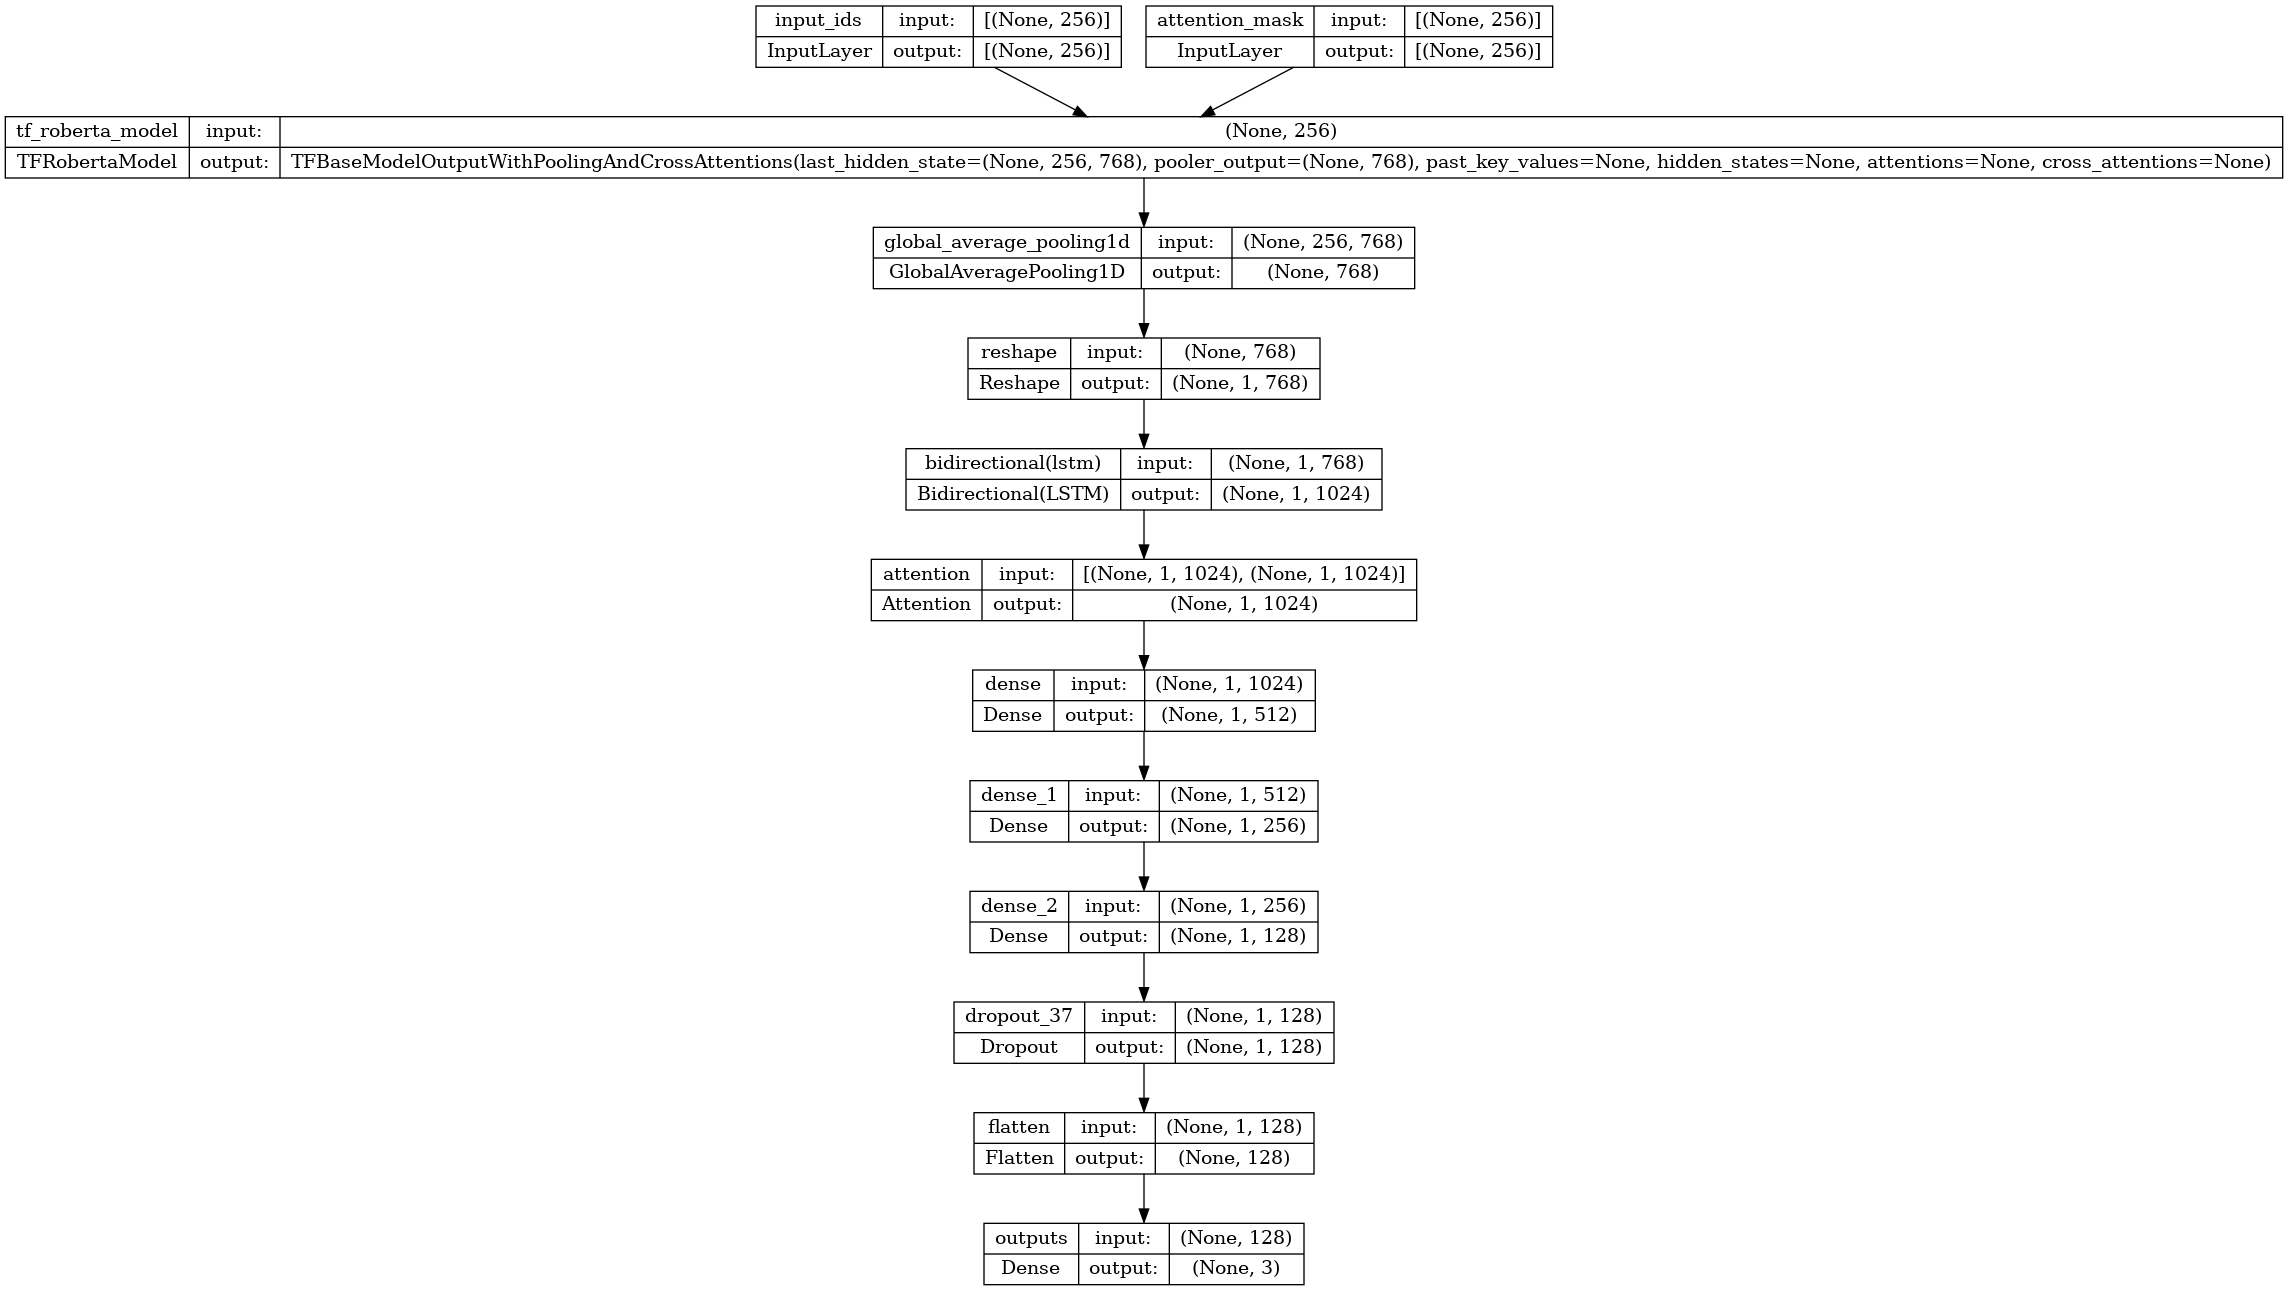

In [42]:
tf.keras.utils.plot_model(bert_model, to_file = 'bert_model1.png', show_shapes=True, show_layer_names = True)

# 📊 Model Evaluation

In [22]:
# For Data Visualization
!pip install plotly 
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random
from IPython import display

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 51.9 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [23]:
def plot_learning_evolution(r):
    plt.figure(figsize=(8, 6))
    
    #plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during training')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('loss1.png')
    
    plt.figure(figsize=(8, 6))
    #plt.subplot(2, 2, 2)
    plt.plot(r.history['categorical_accuracy'], label='categorical_accuracy')
    plt.plot(r.history['val_categorical_accuracy'], label='val_categorical_accuracy')
    plt.title('Accuracy score evolution during training')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.savefig('accuracy1.png')

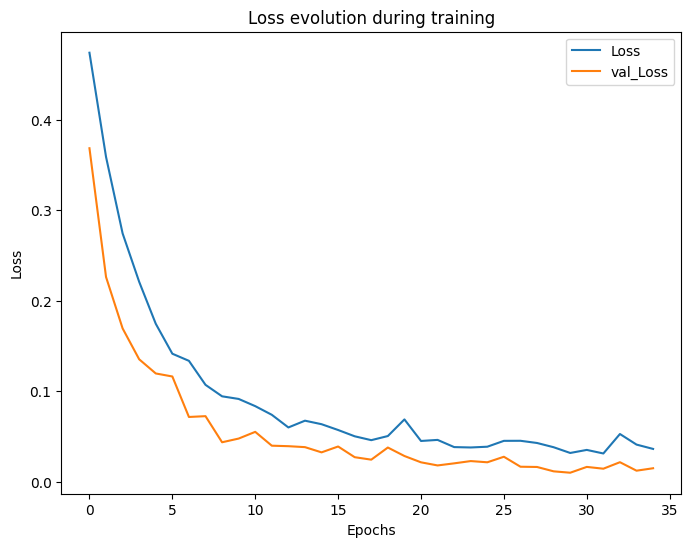

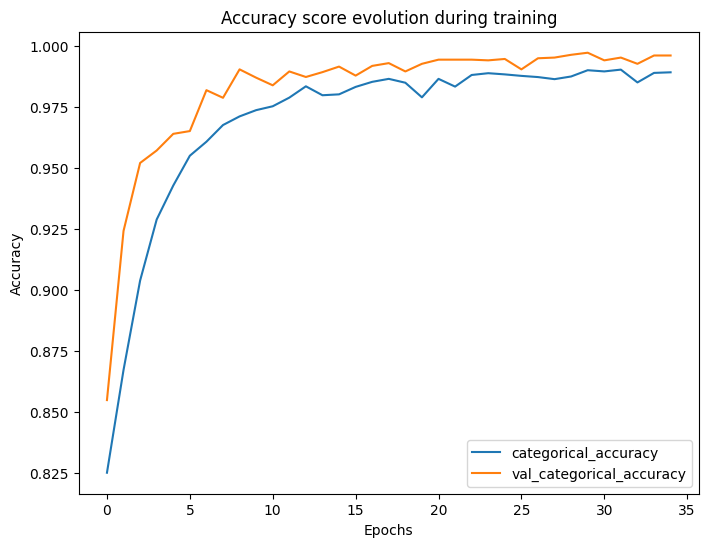

In [24]:
plot_learning_evolution(history)

In [25]:
bert_model.evaluate(val_ds)

220/220 [==============================] - 5s 14ms/step - loss: 0.0120 - categorical_accuracy: 0.9952


[0.012018894776701927, 0.9951704740524292]

In [26]:
bert_model.evaluate(train_ds)

512/512 [==============================] - 9s 15ms/step - loss: 0.0159 - categorical_accuracy: 0.9949


[0.015910014510154724, 0.994873046875]

In [27]:
def prep_data(text):
    tokens = tokenizer(
        text, max_length=seq_len, truncation=True, 
        padding='max_length', 
        add_special_tokens=True, 
        return_tensors='tf'
    )
    return {
        'input_ids': tokens['input_ids'], 
        'attention_mask': tokens['attention_mask']
    }

test['prediction'] = None

for i, row in test.iterrows():
    tokens = prep_data(row['text'])
    #probs = bert_model.predict(tokens)
    probs = bert_model.predict_on_batch(tokens)
    pred = np.argmax(probs)
    test.at[i, 'prediction'] = pred
    
test['prediction'] = test['prediction'].astype(int)
test

2023-05-21 19:20:24.965111: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-21 19:20:25.198353: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


,text,target,prediction
4794,SouthwestAir youre my early frontrunner for be...,2,2
10480,USAirways how is it that my flt to EWR was Can...,0,0
8067,JetBlue what is going on with your BDL to DCA ...,0,0
8880,JetBlue do they have to depart from Washington DC,1,1
8292,JetBlue I can probably find some of them Are t...,0,1
...,...,...,...
11765,USAirways on hold for 2 hours You know what ju...,0,0
14156,AmericanAir how hard is it to have catering re...,0,1
10963,USAirways AmericanAir Im in the finalstretch t...,1,1
4877,SouthwestAir Well we all need something to aim...,1,0


In [28]:
labels = ['Negative','Neutral','Positive']
from sklearn.metrics import classification_report
print(classification_report(test['target'], test['prediction'], target_names=labels))

              precision    recall  f1-score   support

    Negative       0.92      0.90      0.91      1889
     Neutral       0.67      0.69      0.68       580
    Positive       0.78      0.80      0.79       459

    accuracy                           0.84      2928
   macro avg       0.79      0.80      0.79      2928
weighted avg       0.85      0.84      0.85      2928



In [29]:
test.head()

,text,target,prediction
4794,SouthwestAir youre my early frontrunner for be...,2,2
10480,USAirways how is it that my flt to EWR was Can...,0,0
8067,JetBlue what is going on with your BDL to DCA ...,0,0
8880,JetBlue do they have to depart from Washington DC,1,1
8292,JetBlue I can probably find some of them Are t...,0,1


In [30]:
test.target.value_counts()

target
0    1889
1     580
2     459
Name: count, dtype: int64

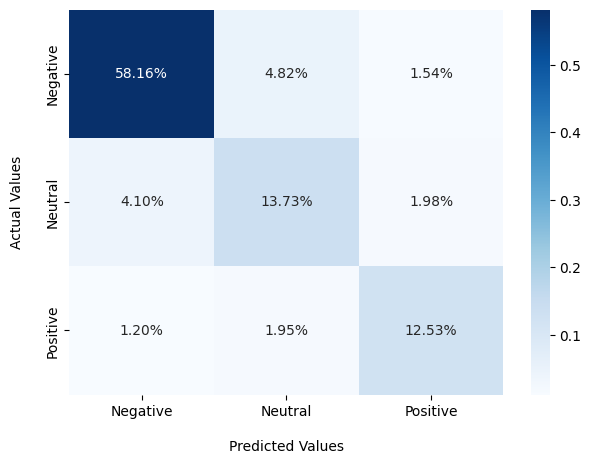

In [31]:
from sklearn.metrics import *
cm = confusion_matrix(test['target'], test['prediction'])

plt.figure(figsize=(7,5))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.savefig('cm.png')
plt.show()

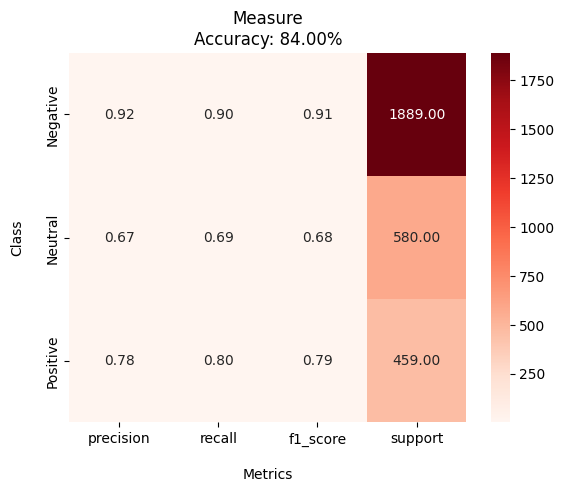

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


def plot_classification_report(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[1:-3]:
        row = {}
        row_data = line.split()
        row_data = list(filter(None, row_data))
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    df.set_index('class', inplace=True)
    heatmap = sns.heatmap(df, annot=True, cmap='Reds', fmt='.2f')
    heatmap.set_xlabel('\nMetrics')
    heatmap.set_ylabel('Class\n')
    heatmap.set_title('Classification Report')


def accuracy_score(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[4:-2]:
        row_data = line.split()
        row_data = list(filter(None, row_data))
        return float(row_data[1])


labels = ['Negative','Neutral','Positive']

report = classification_report(test['target'], test['prediction'], target_names=labels)
plot_classification_report(report)
accuracy = accuracy_score(report)

plt.title('Measure\nAccuracy: {:.2f}%'.format(accuracy*100))
plt.savefig('classification_reports.png')
plt.show()
